<a href="https://colab.research.google.com/github/rohitgoyal2000/virtual-try-on/blob/main/traditional_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

dataset_path = "/content/drive/MyDrive/virtual-try-on/datasets.zip"  # Uploaded file name
extract_dir = "viton_dataset"

# Unzip dataset
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Check extracted files
print("Dataset Structure:")
for folder in os.listdir(extract_dir):
    print("-", folder)


Dataset Structure:
- ACGPN_TestData
- ACGPN_TrainData
- partition_label


In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#############################
# Step A: Load Data
#############################
def load_images(base_name, root_dir='viton_dataset/ACGPN_TestData'):
    person_path = f"{root_dir}/test_img/{base_name}_0.jpg"
    cloth_path = f"{root_dir}/test_color/{base_name}_1.jpg"
    label_path = f"{root_dir}/test_label/{base_name}_0.png"

    person = cv2.imread(person_path)
    cloth = cv2.imread(cloth_path)
    label = cv2.imread(label_path, 0)

    # Resize
    person = cv2.resize(person, (192, 256))
    cloth = cv2.resize(cloth, (192, 256))
    label = cv2.resize(label, (192, 256), interpolation=cv2.INTER_NEAREST)

    return person, cloth, label

In [25]:
#############################
# Step B: Agnostic
#############################
def create_agnostic(person, label):
    # Mask out label=4 region
    mask = (label == 4).astype(np.uint8)
    # Use larger kernel for better coverage
    kernel = np.ones((7, 7), np.uint8)
    dilated = cv2.dilate(mask, kernel, iterations=2)
    agnostic = person.copy()
    agnostic[dilated == 1] = [128, 128, 128]
    return agnostic, dilated

In [26]:
#############################
# Step C: Find BBox of label==4
#############################
def find_label_bbox(label):
    ys, xs = np.where(label == 4)
    if len(xs) == 0 or len(ys) == 0:
        return None
    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()
    # Add padding to the bounding box
    padding_x = int((x_max - x_min) * 0.05)
    padding_y = int((y_max - y_min) * 0.05)
    x_min = max(0, x_min - padding_x)
    y_min = max(0, y_min - padding_y)
    x_max = min(label.shape[1] - 1, x_max + padding_x)
    y_max = min(label.shape[0] - 1, y_max + padding_y)
    return (x_min, y_min, x_max, y_max)

In [27]:
#############################
# Step D: Improved Cloth Warping
#############################
def improved_warp_cloth(cloth, person, label):
    # Get mask for label==4
    mask = (label == 4).astype(np.uint8) * 255

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return cloth

    # Find the largest contour
    cnt = max(contours, key=cv2.contourArea)

    # Get a tight bounding box for the contour
    x, y, w, h = cv2.boundingRect(cnt)

    # Extract source points from cloth (corners of the cloth image)
    src_h, src_w = cloth.shape[:2]
    src_points = np.array([
        [0, 0],
        [src_w - 1, 0],
        [src_w - 1, src_h - 1],
        [0, src_h - 1]
    ], dtype=np.float32)

    # Add some padding to ensure we cover the entire region
    padding_x = int(w * 0.05)
    padding_y = int(h * 0.05)

    # Extract destination points from the person contour
    dst_points = np.array([
        [max(0, x - padding_x), max(0, y - padding_y)],
        [min(person.shape[1] - 1, x + w + padding_x), max(0, y - padding_y)],
        [min(person.shape[1] - 1, x + w + padding_x), min(person.shape[0] - 1, y + h + padding_y)],
        [max(0, x - padding_x), min(person.shape[0] - 1, y + h + padding_y)]
    ], dtype=np.float32)

    # Compute perspective transform
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    warped_cloth = cv2.warpPerspective(cloth, M, (person.shape[1], person.shape[0]),
                                       borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))

    # Create a mask for the warped cloth
    gray_warped = cv2.cvtColor(warped_cloth, cv2.COLOR_BGR2GRAY)
    _, warped_mask = cv2.threshold(gray_warped, 10, 255, cv2.THRESH_BINARY)

    # Refine mask to remove artifacts
    kernel = np.ones((3, 3), np.uint8)
    warped_mask = cv2.morphologyEx(warped_mask, cv2.MORPH_CLOSE, kernel)
    warped_mask = cv2.morphologyEx(warped_mask, cv2.MORPH_OPEN, kernel)

    # Apply the mask to the warped cloth
    warped_cloth_masked = cv2.bitwise_and(warped_cloth, warped_cloth, mask=warped_mask)

    return warped_cloth_masked

In [28]:
#############################
# Step E: Improved Blending
#############################
def improved_blend(agnostic, warped_cloth, label):
    # Create a mask for the target area (where label==4)
    target_mask = (label == 4).astype(np.uint8)
    kernel = np.ones((9, 9), np.uint8)
    target_mask = cv2.dilate(target_mask, kernel, iterations=2) * 255

    # Create a mask for the warped cloth
    gray_warped = cv2.cvtColor(warped_cloth, cv2.COLOR_BGR2GRAY)
    _, cloth_mask = cv2.threshold(gray_warped, 10, 255, cv2.THRESH_BINARY)

    # Combine masks to ensure we only blend in the target area
    combined_mask = cv2.bitwise_and(target_mask, cloth_mask)

    # Apply Gaussian blur to the mask edges for smoother blending
    combined_mask = cv2.GaussianBlur(combined_mask, (5, 5), 0)

    # Prepare for seamless cloning
    # Find center of mass of the mask
    M = cv2.moments(combined_mask)
    if M["m00"] != 0:
        center_x = int(M["m10"] / M["m00"])
        center_y = int(M["m01"] / M["m00"])
        center = (center_x, center_y)
    else:
        center = (agnostic.shape[1] // 2, agnostic.shape[0] // 2)

    # Apply seamless cloning
    try:
        output = cv2.seamlessClone(warped_cloth, agnostic, combined_mask, center, cv2.NORMAL_CLONE)
    except cv2.error:
        # Fallback if seamless cloning fails
        output = agnostic.copy()
        mask_3d = np.stack([combined_mask / 255.0] * 3, axis=2)
        output = warped_cloth * mask_3d + output * (1 - mask_3d)
        output = output.astype(np.uint8)

    return output

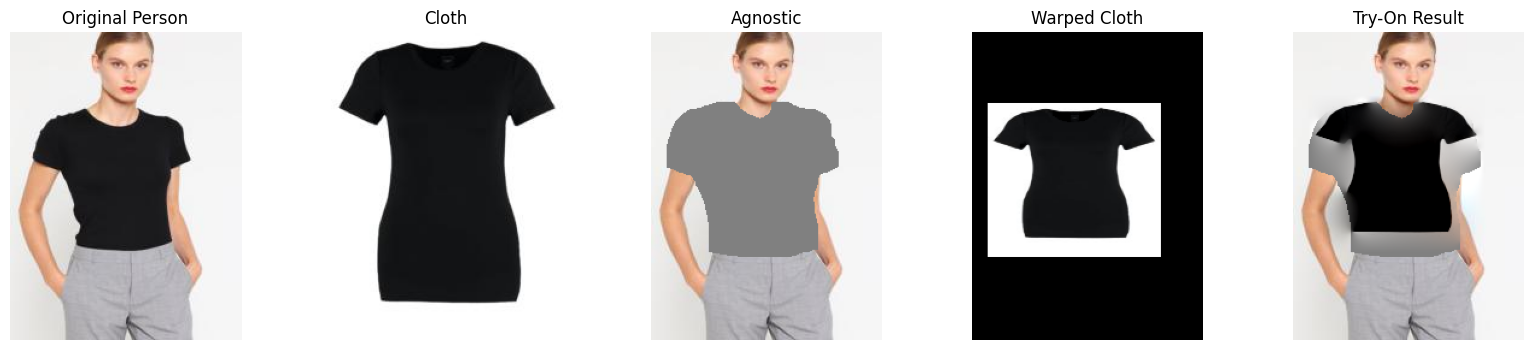

In [29]:
#############################
# Visualization
#############################
def show_results(person, cloth, agnostic, warped, final_out):
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    images = [person, cloth, agnostic, warped, final_out]
    titles = ["Original Person", "Cloth", "Agnostic", "Warped Cloth", "Try-On Result"]
    for i in range(5):
        axs[i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        axs[i].set_title(titles[i])
        axs[i].axis('off')
    plt.show()

#############################
# MAIN RUN
#############################
if __name__ == "__main__":
    base_name = "017418"
    person, cloth, label = load_images(base_name)
    agnostic, dilated_mask = create_agnostic(person, label)

    # Use improved cloth warping function
    warped_cloth = improved_warp_cloth(cloth, person, label)

    # Use improved blending function
    final_output = improved_blend(agnostic, warped_cloth, label)

    show_results(person, cloth, agnostic, warped_cloth, final_output)

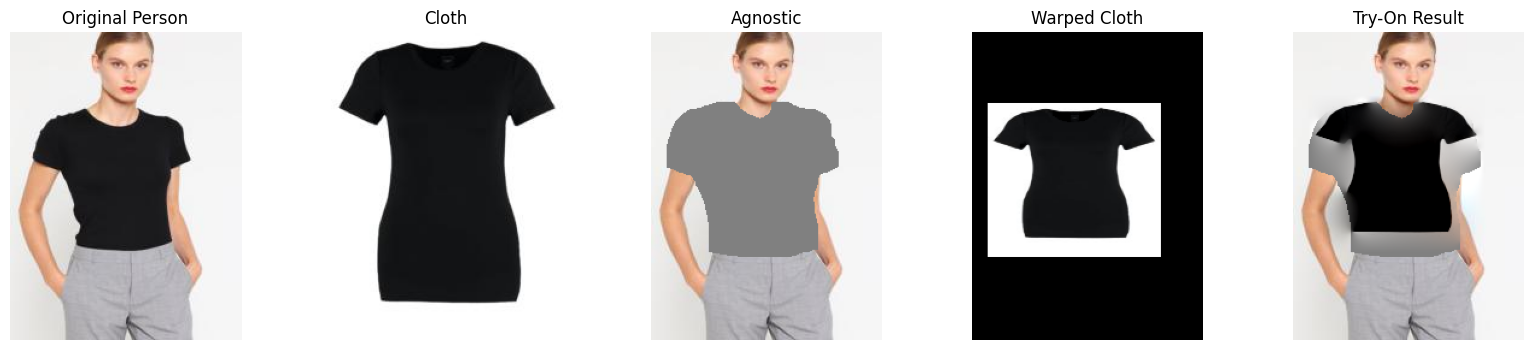